# Step 1: remove the flight effects from the sensors

In [11]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
import tensorflow_addons as tfa

import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/oem/phm2021_data_challenge
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# THESE ARE YOUR CREDENTIALS IN PLAIN TEXT!
params = utils.get_aws_secret("/secret/cmapss")
#print(params)
db, cur =  api.connect(params)
db.set_session(autocommit=True)
del(params)

[INFO] connecting to db.
[INFO] connected.


### use all units, downsample by a factor of 20, convert from f64 to f32

In [33]:
units = api._get_units(db=db)
units[0:10]

,id,serial_number,age,eol,rul,group_id,Fc,unit,dataset
0,1,HD3QgeG7,0.0,100.0,100.0,1,1,1,DS01-005
1,2,BUcOUKMQ,0.0,75.0,75.0,1,3,2,DS01-005
2,3,6n1MJJrg,0.0,100.0,100.0,1,2,3,DS01-005
3,4,3Ewe04EX,0.0,95.0,95.0,1,1,4,DS01-005
4,5,RXPSDX5O,0.0,89.0,89.0,1,3,5,DS01-005
5,6,oKlALxDg,0.0,94.0,94.0,1,2,6,DS01-005
6,7,7dRr8CZy,0.0,90.0,90.0,2,1,7,DS01-005
7,8,SMLGbntz,0.0,89.0,89.0,2,2,8,DS01-005
8,9,M2YaAZVX,0.0,80.0,80.0,2,1,9,DS01-005
9,10,qnkiQU4v,0.0,82.0,82.0,2,3,10,DS01-005


In [94]:
df = api._get_data(db=db, 
                   units=pd.unique(units.id), 
                   tables=['summary_tb', 'telemetry_tb'], 
                   downsample=20).astype(np.float32)
df

,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50
0,1.0,1.0,3153.0,0.38449,70.575668,522.428162,1.0,20.0,1.0,4.62365,...,1471.050293,1850.533203,1268.849243,19.423830,14.47184,19.719620,24.418449,394.727753,401.229858,15.91869
1,1.0,1.0,3305.0,0.39438,70.575668,522.651184,1.0,40.0,1.0,4.61099,...,1470.762817,1849.517334,1267.364746,19.410761,14.46770,19.706360,24.409960,393.944061,400.443970,15.84730
2,1.0,1.0,3490.0,0.39835,70.927231,522.289795,1.0,60.0,1.0,4.60390,...,1470.901489,1850.212769,1266.849121,19.338869,14.40033,19.633369,24.338350,393.143677,399.622711,15.76343
3,1.0,1.0,3680.0,0.39860,71.103012,521.611267,1.0,80.0,1.0,4.57878,...,1469.811401,1849.202881,1265.744385,19.215719,14.30136,19.508350,24.190639,391.051056,397.489471,15.66137
4,1.0,1.0,3843.0,0.40219,71.190903,521.301880,1.0,100.0,1.0,4.55938,...,1469.048584,1848.210815,1264.574219,19.139681,14.24302,19.431150,24.101110,389.533295,395.947296,15.57763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169150,54.0,0.0,3132.0,0.24791,32.255630,513.740479,2.0,63383020.0,90.0,2.39278,...,1290.521606,1543.293213,1152.979858,16.245251,13.63885,16.492640,18.840670,243.525665,248.289337,14.32857
3169151,54.0,0.0,3178.0,0.22667,34.980221,512.551575,2.0,63383040.0,90.0,2.54319,...,1303.055908,1575.256104,1169.733887,16.249741,13.52102,16.497200,18.930401,252.430084,257.153351,14.41061
3169152,54.0,0.0,3181.0,0.21502,40.341511,512.017090,2.0,63383060.0,90.0,2.77681,...,1326.987671,1614.792847,1182.485840,16.510420,13.47124,16.761850,19.491110,269.614899,274.555573,14.52894
3169153,54.0,0.0,3110.0,0.21559,40.341511,512.295837,2.0,63383080.0,90.0,2.78551,...,1327.620850,1615.702026,1183.192993,16.555651,13.50874,16.807770,19.544340,270.338898,275.291595,14.56780


### add a positional variable to give the time within a cycle

In [95]:
df['time'] = ""
for unit in pd.unique(units.id):
    for cycle in pd.unique(df[df.asset_id == unit].cycle):
        length = len(df[(df.asset_id == unit) & (df.cycle == cycle)])
        x = np.arange(0, length)/(length-1)
        df.loc[(df.asset_id == unit) & (df.cycle == cycle), 'time'] = x

### train on only hs == 1

In [96]:
df1 = df[(df.hs == 1)]

In [ ]:
# utils.plot_feature_distributions(df=df1, feature_range=(-1,1), figsize=(12,4))

In [ ]:
# sns.pairplot(df1, diag_kind='kde')

### split into train, test, val sets

In [ ]:
#print(df1.columns)

In [97]:
X_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']## disregard comments #, 'Fc'] # will also have Fc_1, Fc_2, Fc_3
y_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']

X = df1[X_cols]
y = df1[y_cols]
## disregard # X = pd.concat([df1[X_cols], pd.get_dummies(df1['Fc']).rename(columns = lambda x: 'Fc_' + str(int(x)))], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=np.random.randint(1000), shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=np.random.randint(1000), shuffle=True)

### normalize data

In [98]:
feature_range = (0,1)

xscaler = MinMaxScaler(feature_range=feature_range)
X_train_scaled = xscaler.fit_transform(X_train)
X_val_scaled = xscaler.transform(X_val)
X_test_scaled = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=feature_range)
y_train_scaled = yscaler.fit_transform(y_train)
y_val_scaled = yscaler.transform(y_val)
y_test_scaled = yscaler.transform(y_test)

### get a sample for after training testing

T30


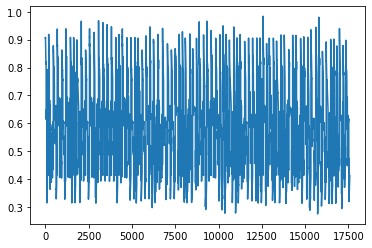

In [99]:
idx = 4
asset_id = 9
print(y_cols[idx])

y_full = df[df.asset_id == asset_id][y_cols]
X_full = df[df.asset_id == asset_id][X_cols]
## disregard
#X_full = pd.concat([df[df.asset_id == asset_id][X_cols], pd.get_dummies(df[df.asset_id == asset_id]['Fc']).rename(columns = lambda x: 'Fc_' + str(int(x)))], axis=1)
#X_full = X_full[X_full.asset_id == asset_id]
trace = yscaler.transform(y_full)[:,idx]

plt.plot(trace)
plt.show()

## build, compile, train, plot results

In [100]:
input_shape = (len(X_train.keys()),)
output_shape = len(y_train.keys())
print(input_shape)
print(output_shape)

(5,)
14


Epoch 1/200
1424/1424 [==============================] - 3s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 2.5592e-05 - val_root_mean_squared_error: 0.0051 - lr: 0.0010
Epoch 2/200
1424/1424 [==============================] - 3s 2ms/step - loss: 9.3337e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.2861e-05 - val_root_mean_squared_error: 0.0036 - lr: 0.0010
Epoch 3/200
1424/1424 [==============================] - 3s 2ms/step - loss: 9.7651e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.2046e-05 - val_root_mean_squared_error: 0.0035 - lr: 9.5000e-04
Epoch 4/200
1424/1424 [==============================] - 3s 2ms/step - loss: 9.1618e-06 - root_mean_squared_error: 0.0030 - val_loss: 4.7324e-06 - val_root_mean_squared_error: 0.0022 - lr: 9.0250e-04
Epoch 5/200
1424/1424 [==============================] - 3s 2ms/step - loss: 8.1610e-06 - root_mean_squared_error: 0.0029 - val_loss: 3.0196e-06 - val_root_mean_squared_error: 0.0017 - lr: 8.5737e-04
Epoch 6/200


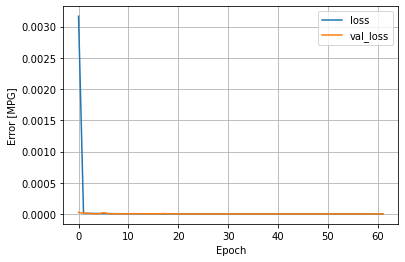

In [101]:
batch_size = 512
epochs = 200

monitor = 'val_root_mean_squared_error'
mode = 'min'
min_delta = .0001
patience = 40

inputs = keras.Input(shape=input_shape, name='in1')
x = layers.Dense(units=70, activation='relu', name='hd1')(inputs)
x = layers.Dense(units=105, activation='relu', name='hd2')(x)
x = layers.Dense(units=140, activation='relu', name='hd3')(x)
x = layers.Dense(units=105, activation='relu', name='hd4')(x)
x = layers.Dense(units=70, activation='relu', name='hd5')(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=.001), loss='mse', metrics=[metrics.RootMeanSquaredError()])

def decay_schedule(epoch, lr):
    if epoch > 1:
        lr = lr * .95
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(decay_schedule)

early_stopping = keras.callbacks.EarlyStopping(monitor=monitor,
                                               mode=mode,
                                               min_delta=min_delta,
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=False)#True)

history = model.fit(X_train_scaled,
                    y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled, y_val_scaled),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

utils.plot_loss(history)

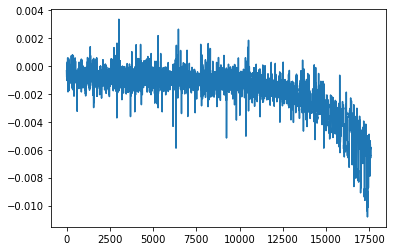

In [102]:
pred = model.predict(xscaler.transform(X_full))[:,idx]
res = trace - pred

plt.plot(res)
plt.show()

In [84]:
save_dir = 'models/ncmapss/'
name = 'flight_effects'

model.save(save_dir + name + '.h5')
model.save(save_dir + name)

with open(save_dir + name + '_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

INFO:tensorflow:Assets written to: models/ncmapss/flight_effects/assets
